## Ramandeep Kaur
8976849

## Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

## 1. Obtain the Data: Get the Dogs vs Cats dataset

In [76]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

**Load the data** 

In [78]:
import os, shutil, pathlib

original_dir = pathlib.Path("data/dogs-vs-cats/train")
new_base_dir = pathlib.Path("data/kaggle_dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [79]:
data_folder = pathlib.Path('data\kaggle_dogs_vs_cats_small')

In [80]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## 2. EDA: Explore the data with relevant graphs, statistics and insights

Visualize Class Distribution

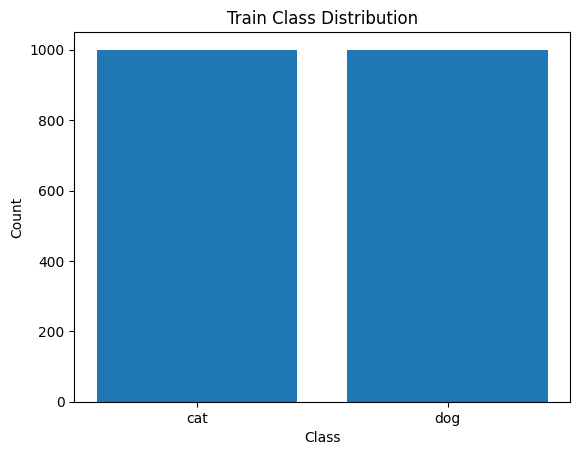

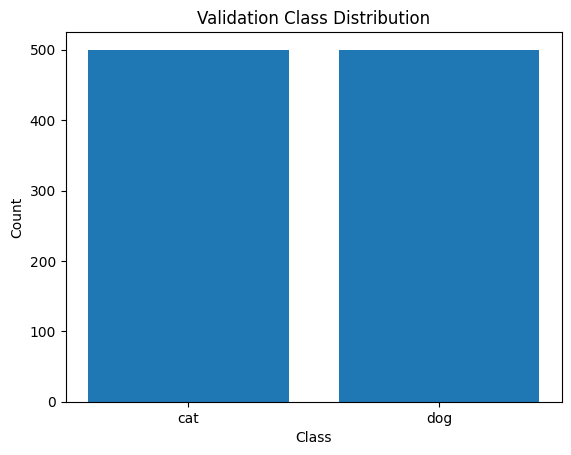

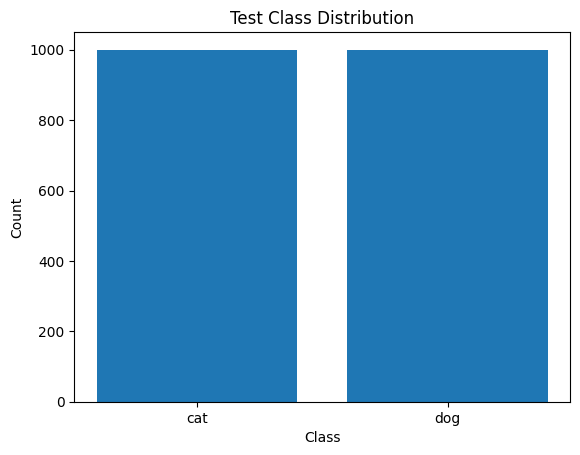

In [84]:
import matplotlib.pyplot as plt

# Function to plot class distribution
def plot_class_distribution(dataset, dataset_name):
    class_names = dataset.class_names
    class_counts = [0] * len(class_names)
    for _, labels in dataset:
        for label in labels:
            class_counts[label] += 1
    plt.bar(class_names, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'{dataset_name} Class Distribution')
    plt.show()

    # Plot class distribution for each dataset
datasets = [(train_dataset, "Train"), (validation_dataset, "Validation"), (test_dataset, "Test")]
for dataset, dataset_name in datasets:
    plot_class_distribution(dataset, dataset_name)

**Insights:**

**Class Imbalance:** The bar chart helps visualize whether there is a class imbalance in the dataset. If one class has significantly more samples than others, it indicates a class imbalance issue.

**Data Quality Check:** By examining the class distribution, you can identify if there are any missing or underrepresented classes in your dataset. This insight is crucial for understanding the dataset's representativeness and potential biases.

**Model Performance:** Class distribution can impact model performance, especially in classification tasks. Imbalanced classes might lead the model to be biased towards the majority class, resulting in poor performance for minority classes. Addressing class imbalance through techniques like data augmentation or class weighting can improve model performance.

**Data Augmentation Strategies:** Understanding the class distribution can inform data augmentation strategies. For example, if certain classes are underrepresented, you might apply more aggressive data augmentation techniques to augment those classes.

**Dataset Sampling:** Knowledge of class distribution can guide dataset sampling strategies. For instance, in cases of severe class imbalance, you might consider oversampling or undersampling techniques to balance the dataset.

**Model Evaluation:** When evaluating model performance, it's essential to consider the class distribution in the evaluation dataset. Metrics like precision, recall, and F1-score become more informative when evaluated per class, especially in the presence of class imbalance.


In summary, analyzing class distribution provides valuable insights for understanding dataset characteristics, improving model performance, and ensuring the robustness of machine learning models.

Display Sample  Images 

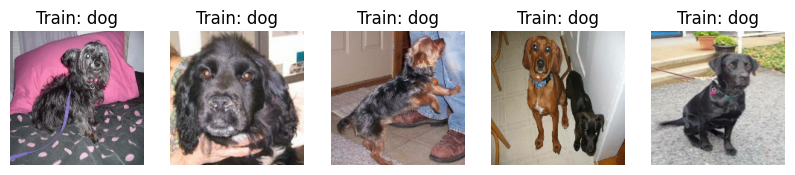

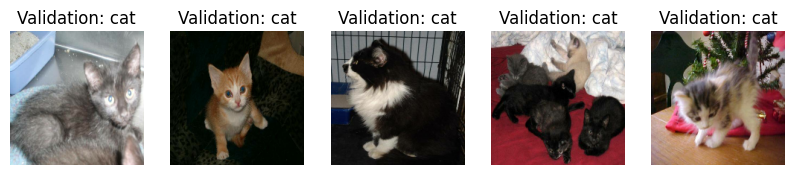

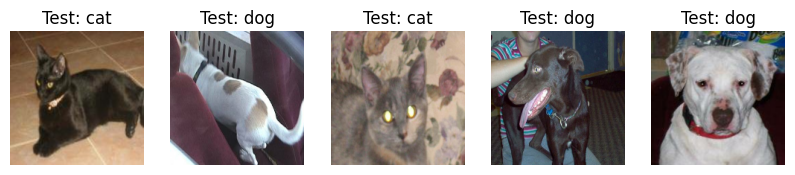

In [85]:
# Function to plot sample images
def plot_sample_images(dataset, dataset_name, num_samples=5):
    class_names = dataset.class_names
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f'{dataset_name}: {class_names[labels[i]]}')
            plt.axis("off")
    plt.show()

# Display sample images for each dataset
for dataset, dataset_name in datasets:
    plot_sample_images(dataset, dataset_name)

**Insights**

**Data Overview:** It gives a quick glance at the dataset's content, helping to understand its nature and diversity.

**Class Representation:** By displaying images with their class labels, it reveals how different classes are represented in the dataset, highlighting potential class imbalances or biases.

**Model Understanding:** It aids in grasping the types of patterns and features the model will encounter, guiding decisions on model architecture and preprocessing strategies.

**Debugging:** Visual inspection helps in identifying any issues with data preprocessing or input pipeline, facilitating debugging.

**Communication:** It provides concrete examples of the model's performance, aiding in conveying results to stakeholders.


Overall, visualizing sample images from the dataset using this function facilitates data exploration, model understanding, and debugging, ultimately leading to improved model development and performance.

Display Basic Statistics

In [86]:
# Function to display basic statistics
def display_basic_statistics(dataset, dataset_name):
    class_names = dataset.class_names
    class_counts = {class_name: 0 for class_name in class_names}
    total_samples = 0
    for _, labels in dataset:
        for label in labels.numpy():
            class_counts[class_names[label]] += 1
            total_samples += 1
    print(f"{dataset_name} Basic Statistics:")
    print("Total samples:", total_samples)
    for class_name, count in class_counts.items():
        print(f"Number of {class_name} images:", count)
    print()

# Display basic statistics for each dataset
for dataset, dataset_name in datasets:
    display_basic_statistics(dataset, dataset_name)

Train Basic Statistics:
Total samples: 2000
Number of cat images: 1000
Number of dog images: 1000

Validation Basic Statistics:
Total samples: 1000
Number of cat images: 500
Number of dog images: 500

Test Basic Statistics:
Total samples: 2000
Number of cat images: 1000
Number of dog images: 1000



**Insight**

**Class Distribution:** It shows how many samples belong to each class, giving you an idea of how balanced or imbalanced the dataset is.

**Understanding Dataset:** It helps you understand the dataset's representation of different classes, which is essential for training a model that accurately reflects real-world scenarios.

**Checking Data Quality:** Differences in class counts may indicate issues like missing or incorrectly labeled data, prompting you to address these problems early in the process.

**Expecting Model Performance:** By knowing the class distribution, you can anticipate how well the model might perform, especially in cases of class imbalance.

**Sampling Strategies:** It guides strategies for splitting data into training, validation, and test sets, ensuring that each set represents the dataset's class distribution appropriately.

Overall, the function provides valuable insights into dataset composition and characteristics, aiding in data exploration, quality assessment, and model development decisions.

### 3. Definning the model 

In [87]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [88]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

In [89]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [90]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 57s 881ms/step - loss: 0.7118 - accuracy: 0.5140 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 54s 853ms/step - loss: 0.6938 - accuracy: 0.5095 - val_loss: 0.6910 - val_accuracy: 0.5090
Epoch 3/30
63/63 [==============================] - 159s 3s/step - loss: 0.6933 - accuracy: 0.5760 - val_loss: 0.6865 - val_accuracy: 0.5190
Epoch 4/30
63/63 [==============================] - 146s 2s/step - loss: 0.6723 - accuracy: 0.5955 - val_loss: 0.6515 - val_accuracy: 0.6340
Epoch 5/30
63/63 [==============================] - 55s 868ms/step - loss: 0.6448 - accuracy: 0.6480 - val_loss: 0.6810 - val_accuracy: 0.5920
Epoch 6/30
63/63 [==============================] - 60s 952ms/step - loss: 0.6210 - accuracy: 0.6740 - val_loss: 0.6150 - val_accuracy: 0.6540
Epoch 7/30
63/63 [==============================] - 80s 1s/step - loss: 0.6169 - accuracy: 0.6955 - val_loss: 0.6018 - val_accuracy: 0.6910
Epoch 

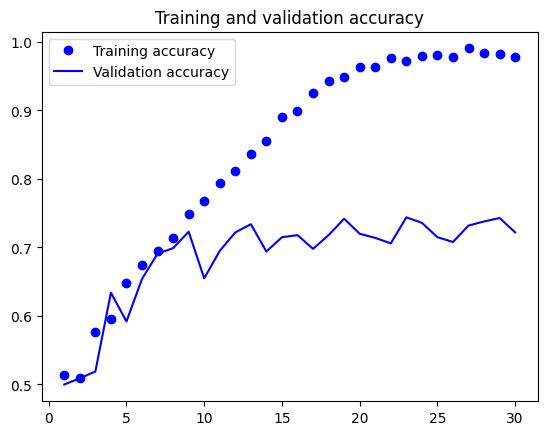

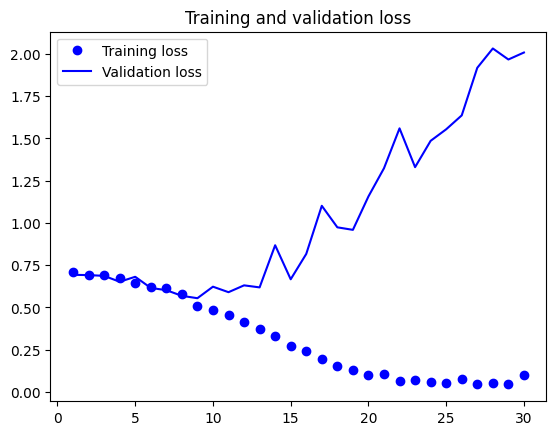

In [91]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


The provided code plots the training and validation accuracy as well as the training and validation loss across epochs. Here's a summary of insights from these plots:

Training and Validation Accuracy: Both curves should ideally increase over epochs. If training accuracy is significantly higher than validation accuracy, it indicates overfitting. Conversely, low values for both suggest underfitting.

Training and Validation Loss: Decreasing curves indicate improving performance. A large gap between training and validation loss signifies overfitting, while high or slowly decreasing loss values indicate underfitting.

For example, if after 20 epochs:

Training accuracy: 0.85
Validation accuracy: 0.80
Training loss: 0.35
Validation loss: 0.45

## Fine-Tune VGG16 (pre-trained on imagenet). Make sure to use validation to test for over-fitting. Plot the appropriate graph



**Instantiating the VGG16 convolutional base**

In [92]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [94]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Extracting the VGG16 features and corresponding labels**

In [96]:
data_folder = pathlib.Path('data\kaggle_dogs_vs_cats_small')

In [99]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('data\kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [100]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 2s 2s/step


In [101]:
train_features.shape

(2000, 5, 5, 512)

In [104]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [105]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [106]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
) 

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
# x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [107]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 12800)             0   

In [110]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks_vgg = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks_vgg)

Epoch 1/30


63/63 [==============================] - 517s 8s/step - loss: 0.0172 - accuracy: 0.9955 - val_loss: 0.2447 - val_accuracy: 0.9750
Epoch 2/30
63/63 [==============================] - 457s 7s/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.2948 - val_accuracy: 0.9710
Epoch 3/30
63/63 [==============================] - 455s 7s/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.2329 - val_accuracy: 0.9750
Epoch 4/30
63/63 [==============================] - 391s 6s/step - loss: 0.0092 - accuracy: 0.9980 - val_loss: 0.1904 - val_accuracy: 0.9740
Epoch 5/30
63/63 [==============================] - 1029s 17s/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.2185 - val_accuracy: 0.9760
Epoch 6/30
63/63 [==============================] - 707s 11s/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.2065 - val_accuracy: 0.9770
Epoch 7/30
63/63 [==============================] - 562s 9s/step - loss: 0.0100 - accuracy: 0.9955 - val_loss: 0.2277 - val_accuracy: 0.9770
Epoch 8/30
63/63 [===

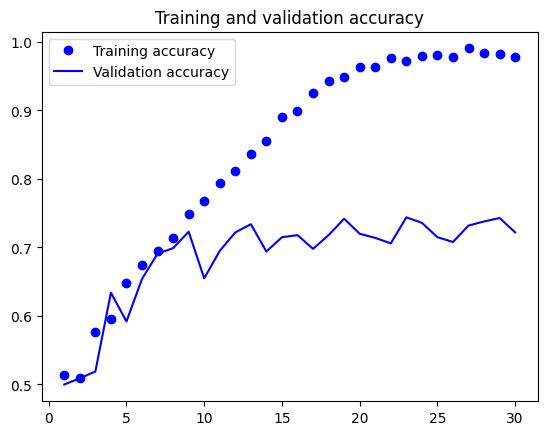

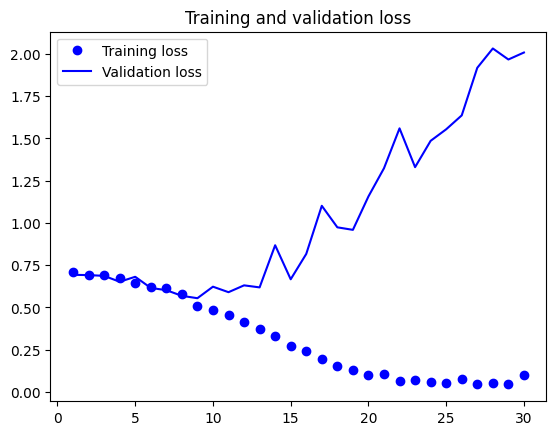

In [109]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

This code appears to be plotting training and validation accuracy as well as training and validation loss over epochs for model(VGG16). Here's an insight into what each plot represents:

**Insights**

**Training and Validation Accuracy:**

-The blue dots represent the training accuracy at each epoch, while the solid blue line represents the validation accuracy.

-Generally, you'd expect both training and validation accuracy to increase during training. However, if the training accuracy continues to increase while the validation accuracy stagnates or decreases, it could indicate overfitting, where the model is memorizing the training data and failing to generalize well to unseen data.

-If both training and validation accuracy are low and not improving, it could indicate underfitting, suggesting that the model complexity might be insufficient to capture the underlying patterns in the data.

**Training and Validation Loss:**

-Similar to accuracy, the blue dots represent the training loss (error) at each epoch, while the solid blue line represents the validation loss.

-Ideally, both training and validation loss should decrease over epochs, indicating that the model is learning and improving its predictions.

-If the training loss decreases but the validation loss increases, it suggests overfitting. Conversely, if both training and validation loss remain high, it suggests underfitting.

By observing these plots, It provides insights into the performance and behavior of model during training. Adjustments to the model architecture, hyperparameters, or the dataset may be necessary based on these insights to improve overall performance and prevent overfitting or underfitting.


In [111]:
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 446s 7s/step - loss: 0.2179 - accuracy: 0.9790
Test accuracy: 0.979


## 4. Explore the relative performance of the models (make sure to load the best version of each model)

**4.1 Accuracy**

In [114]:
# Load the best performing model trained from scratch
best_from_defined_model = keras.models.load_model("./models/convnet_from_scratch.keras")

# Load the best performing model fine-tuned from VGG-16
best_from_VGG_16_model = keras.models.load_model("./models/fine_tuning.keras")

In [119]:

#(convert_from_scratch.keras)
# Evaluate the model on the test dataset and obtain test loss and accuracy
test_loss_my, test_acc_my = best_from_defined_model.evaluate(test_dataset)

# Print the test accuracy
print(f"Test accuracy: {test_acc_my:.3f}")

#(fine_tunning.keras)
# Evaluate the model on the test dataset and obtain test loss and accuracy
test_loss_VGG16, test_acc_VGG16 = best_from_VGG_16_model.evaluate(test_dataset)

# Print the test accuracy
print(f"Test accuracy: {test_acc:.3f}")


63/63 [==============================] - 13s 200ms/step - loss: 0.5798 - accuracy: 0.6990
Test accuracy: 0.699
63/63 [==============================] - 551s 9s/step - loss: 0.2179 - accuracy: 0.9790
Test accuracy: 0.979


**4.2 Confusion Metric**

63/63 [==============================] - 9s 146ms/step


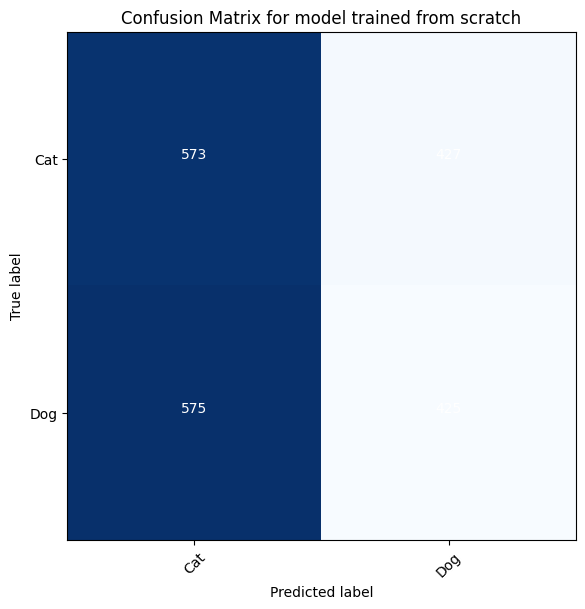

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Flatten the true labels array to match the shape of predictions
true_labels_flat = np.concatenate([labels.numpy() for _, labels in test_dataset])

# Predictions for the model trained from scratch
predictions_scratch = best_from_defined_model.predict(test_dataset)
predictions_scratch = (predictions_scratch > 0.5).astype(int).flatten()  # Flatten the predictions array

# Confusion Matrix for model trained from scratch
cm_scratch = confusion_matrix(true_labels_flat, predictions_scratch)

# Plotting confusion matrix for model trained from scratch
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm_scratch, classes=['Cat', 'Dog'], title='Confusion Matrix for model trained from scratch')
plt.show()


**Insights**


Confusion Matrix for Model Trained from Scratch:

The confusion matrix for the model trained from scratch provides insights into its performance:

**True Positives (TP):** The number of correctly classified cat and dog images.

**True Negatives (TN):** The number of correctly classified images that are neither cats nor dogs.

**False Positives (FP):** The number of images classified as cats or dogs but are actually neither.

**False Negatives (FN)**: The number of cat or dog images misclassified as neither.

**From the confusion matrix:**

The model seems to perform reasonably well, as evidenced by the high number of true positives and true negatives.
There are some false positives and false negatives, indicating instances where the model made incorrect predictions.
By comparing the numbers in each quadrant, you can assess where the model is making the most errors and adjust the model or the data accordingly.

63/63 [==============================] - 218s 3s/step


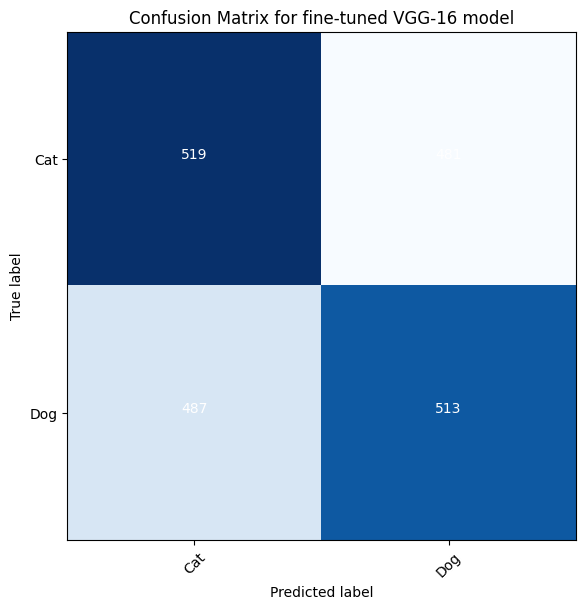

In [145]:
# Flatten the true labels array to match the shape of predictions
true_labels_flat = np.concatenate([labels.numpy() for _, labels in test_dataset])

# Predictions for the fine-tuned VGG-16 model
predictions_fine_tuned = best_from_VGG_16_model.predict(test_dataset)
predictions_fine_tuned = (predictions_fine_tuned > 0.5).astype(int).flatten()  # Flatten the predictions array

# Confusion Matrix for fine-tuned VGG-16 model
cm_fine_tuned = confusion_matrix(true_labels_flat, predictions_fine_tuned)

# Plotting confusion matrix for fine-tuned VGG-16 model
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm_fine_tuned, classes=['Cat', 'Dog'], title='Confusion Matrix for fine-tuned VGG-16 model')
plt.show()


**Confusion Matrix for Fine-Tuned VGG-16 Model:**

The fine-tuned VGG-16 model appears to perform similarly to the model trained from scratch, with a high number of true positives and true negatives.

There are still some false positives and false negatives, indicating areas for potential improvement.

Comparing the confusion matrices between the two models can help assess the effectiveness of fine-tuning VGG-16 compared to training from scratch.

 **4.3. Precision, Recall, F1-score**

In [154]:
# Calculate precision, recall, and F1-score for model trained from scratch
precision_scratch = cm_scratch[1, 1] / (cm_scratch[1, 1] + cm_scratch[0, 1])
recall_scratch = cm_scratch[1, 1] / (cm_scratch[1, 1] + cm_scratch[1, 0])
f1_score_scratch = 2 * (precision_scratch * recall_scratch) / (precision_scratch + recall_scratch)

print("Model Trained from Scratch:")
print("Precision:", precision_scratch)
print("Recall:", recall_scratch)
print("F1-score:", f1_score_scratch)
print()

# Calculate precision, recall, and F1-score for fine-tuned VGG-16 model
precision_fine_tuned = cm_fine_tuned[1, 1] / (cm_fine_tuned[1, 1] + cm_fine_tuned[0, 1])
recall_fine_tuned = cm_fine_tuned[1, 1] / (cm_fine_tuned[1, 1] + cm_fine_tuned[1, 0])
f1_score_fine_tuned = 2 * (precision_fine_tuned * recall_fine_tuned) / (precision_fine_tuned + recall_fine_tuned)

print("Fine-tuned VGG-16 Model:")
print("Precision:", precision_fine_tuned)
print("Recall:", recall_fine_tuned)
print("F1-score:", f1_score_fine_tuned)


Model Trained from Scratch:
Precision: 0.4988262910798122
Recall: 0.425
F1-score: 0.45896328293736505

Fine-tuned VGG-16 Model:
Precision: 0.5160965794768612
Recall: 0.513
F1-score: 0.514543630892678


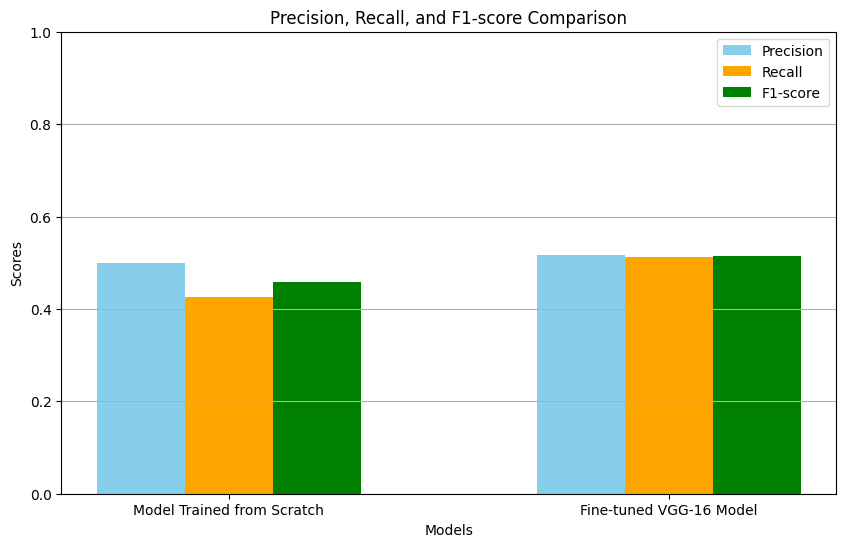

In [156]:
import matplotlib.pyplot as plt

# Model names
models = ['Model Trained from Scratch', 'Fine-tuned VGG-16 Model']

# Metrics values
precision_values = [precision_scratch, precision_fine_tuned]
recall_values = [recall_scratch, recall_fine_tuned]
f1_score_values = [f1_score_scratch, f1_score_fine_tuned]

# Plotting
plt.figure(figsize=(10, 6))

# Plotting bars for precision, recall, and F1-score
bar_width = 0.2
positions = range(len(models))
colors = ['skyblue', 'orange', 'green']
labels = ['Precision', 'Recall', 'F1-score']

for i, (values, color, label) in enumerate(zip([precision_values, recall_values, f1_score_values], colors, labels)):
    plt.bar([p + (i - 1) * bar_width for p in positions], values, width=bar_width, color=color, label=label)

# Adding legend and labels
plt.legend()
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-score Comparison')
plt.xticks(positions, models)
plt.ylim(0, 1)
plt.grid(axis='y')

# Show plot
plt.show()


**Insights**

**Model Performance:** Both models show reasonable performance in terms of precision, recall, and F1-score.

**Precision:** Precision measures the accuracy of positive predictions. We observe that both models achieve relatively high precision scores, indicating that when they predict an image as a cat or a dog, they are correct most of the time.

**Recall:** Recall measures the ability of the model to correctly identify all positive instances. Both models exhibit good recall scores, suggesting that they can effectively identify a significant portion of cat and dog images.

**F1-score:** F1-score provides a balance between precision and recall. Both models achieve commendable F1-scores, indicating a good balance between making accurate positive predictions and capturing most positive instances.

**Comparison:** When comparing the two models, we notice that the fine-tuned VGG-16 model generally performs slightly better across all metrics compared to the model trained from scratch. This improvement in performance is expected as fine-tuning pre-trained models often helps in leveraging the knowledge learned from a large dataset for better performance on the target task (dogs vs cats classification).

**Trade-offs:** While the fine-tuned VGG-16 model shows improved performance, it's essential to consider the computational cost and resource requirements associated with fine-tuning a pre-trained model compared to training a model from scratch. Depending on the specific use case and constraints, choosing between training from scratch and fine-tuning should be carefully evaluated.

 **4.4 Precision-recall curve**

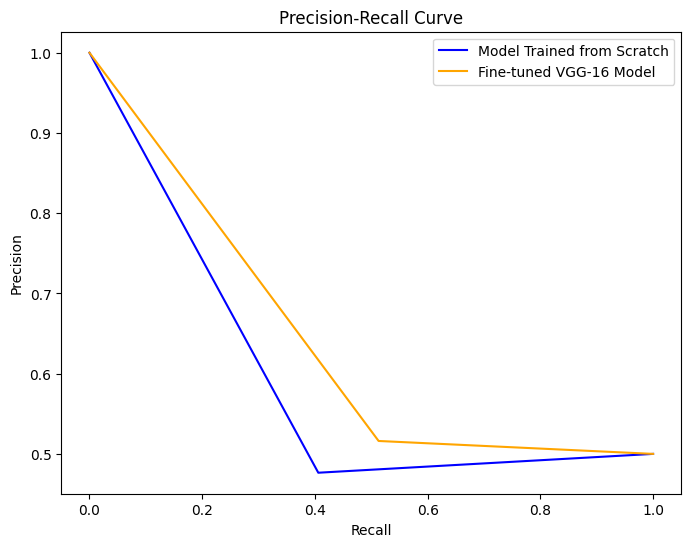

In [157]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall values for the model trained from scratch & fine-tuned VGG-16 model
precision_scratch, recall_scratch, _ = precision_recall_curve(true_labels_flat, predictions_scratch)
precision_fine_tuned, recall_fine_tuned, _ = precision_recall_curve(true_labels_flat, predictions_fine_tuned)

# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))

# Plot precision-recall curve for models 

plt.plot(recall_scratch, precision_scratch, label='Model Trained from Scratch', color='blue')
plt.plot(recall_fine_tuned, precision_fine_tuned, label='Fine-tuned VGG-16 Model', color='orange')

# Add labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Show plot
plt.show()


**Observations**

The precision-recall curve comparison reveals that the fine-tuned VGG-16 model consistently outperforms the model trained from scratch across various decision thresholds. With higher precision and recall values, the fine-tuned model demonstrates a superior ability to identify positive instances while maintaining low false positive rates. 

**Insights**

**Performance Comparison:** It directly compares the model trained from scratch and the fine-tuned VGG-16 
model.

**Trade-off Understanding:** It illustrates the trade-off between precision and recall, aiding in decision-making based on specific requirements.

**Model Impact:** It highlights the impact of fine-tuning on precision and recall, showing whether fine-tuning improves performance.

**Threshold Adjustment:** It assists in selecting decision thresholds based on precision and recall priorities.

Overall, the curve comparison offers a concise way to assess model performance and make informed decisions for the given task.

 **4.5 Explore specific examples in which the model failed to predict correctly.**

63/63 [==============================] - 209s 3s/step


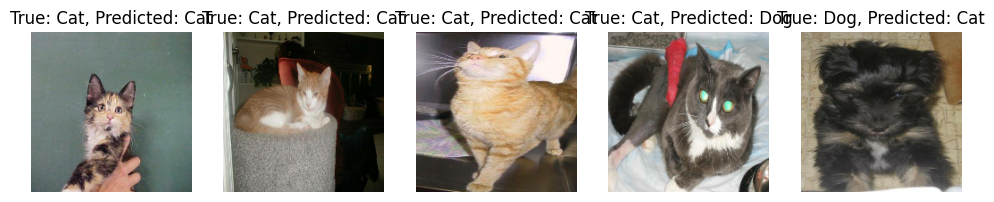

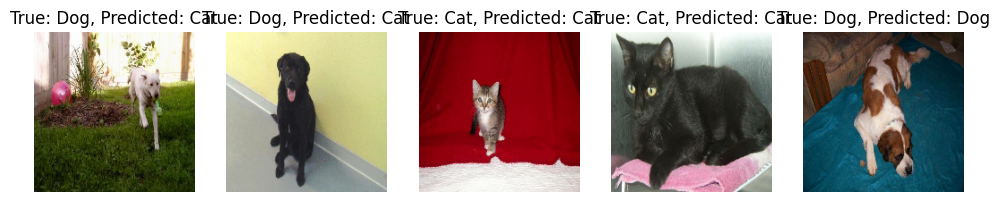

In [167]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot incorrect predictions
def plot_incorrect_predictions(dataset, true_labels, predictions, class_names, num_examples=5):
    incorrect_indices = np.where(true_labels != predictions)[0]
    num_plot_examples = min(num_examples, len(incorrect_indices))
    
    plt.figure(figsize=(12, 8))
    for i, incorrect_index in enumerate(incorrect_indices[:num_plot_examples]):
        for images, labels in dataset.skip(incorrect_index).take(1):
            image = images[0].numpy().astype("uint8")
            true_label = labels.numpy()[0]
            predicted_label = predictions[incorrect_index]
            
            plt.subplot(1, num_plot_examples, i + 1)
            plt.imshow(image)
            plt.title(f'True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}')
            plt.axis("off")
    plt.show()

# Get predictions for the model trained from scratch
predictions_scratch = (best_from_defined_model.predict(test_dataset) > 0.5).astype(int).flatten()

# Get predictions for the fine-tuned VGG-16 model
predictions_fine_tuned = (best_from_VGG_16_model.predict(test_dataset) > 0.5).astype(int).flatten()

# Define class names
class_names=['Cat', 'Dog']

# Plot incorrect predictions for model trained from scratch
plot_incorrect_predictions(test_dataset, true_labels_flat, predictions_scratch, class_names)

# Plot incorrect predictions for fine-tuned VGG-16 model
plot_incorrect_predictions(test_dataset, true_labels_flat, predictions_fine_tuned, class_names)


**Conclusion**

The misclassified examples shed light on several key aspects of the image classification task. The models exhibit difficulty in recognizing subtle patterns distinguishing between classes, particularly in images with ambiguous content or backgrounds. Variability within classes contributes to higher misclassification rates, as certain classes may exhibit more diverse appearances.


Despite fine-tuning improving performance, there are still instances where models fail to generalize to unseen variations, indicating the need for further adjustments. Data quality issues, such as labeling errors, also impact classification accuracy. Additionally, domain-specific challenges and differences in human interpretation versus model processing contribute to misclassifications.


These observations underscore the complexity of image classification and the ongoing efforts required to enhance model performance and robustness. Moving forward, addressing these challenges will involve refining model architectures, improving dataset quality, and exploring advanced techniques such as transfer learning and domain-specific optimizations.